In [1]:
from IPython.core.display import display,HTML
display(HTML("<style>.container {width: 99% !important;}</style>"))

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import pygazeanalyser
import matplotlib
from matplotlib import pyplot as plt
from pygazeanalyser.edfreader import read_edf
from pygazeanalyser import gazeplotter
from scipy import stats, signal, ndimage, interpolate
import re
import os
import mne
import copy
import myfunctions
#from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#%matplotlib
np.set_printoptions(suppress = True)

In [3]:
# set relevant directories and paths
#workingfolder = '/Users/user/Desktop/Experiments/Nick/AttentionSaccade/' #laptop directory
workingfolder = '/home/sammirc/Experiments/Nick/AttentionSaccade' #workstation directory
eyedat        = os.path.join(workingfolder, 'eyes')
behdat        = os.path.join(workingfolder, 'behaviour/csv')
eegdat        = os.path.join(workingfolder, 'EEG') #only on workstation though, no eeg data on laptop
eyelist       = os.listdir(eyedat)
eyelist       = np.sort(eyelist)
behlist       = np.sort(os.listdir(behdat))
saccadedat    = os.path.join(workingfolder, 'saccades')
if not os.path.exists(saccadedat):
    os.mkdir(saccadedat)
sublist = [1,2,3,4, 5, 6, 7, 8, 9]
sublist = [1,2,  4, 5, 6, 7, 8, 9] #subject 3 has 961 trials in eyetracker data, and 960 in behavioural - check with nick. for now, remove from analysis
#sublist = [1,2,     5, 6, 7, 8, 9]
parts   = ['a','b']

epsubs       = [3, 4, 5, 6,9] #subjects who did the task in EP
ohbasubs     = [1, 2, 7 ,8]   #subjects who did the task in OHBA
hrefsubs     = [7, 8]
lowsamp_subs = [4]

#1KHz  sample: 1 5 6 7 8 9
#250Hz sample: 4

# specs for the task
resxy = (1920,1080)
scrsize = (60,34)
scrdist = 100 # cm
#pixpcm = np.mean([resxy[0]/scrsize[0],resxy[1]/scrsize[1]])
#samplerate = 1000.0 # Hz , sample every 1ms. subject 4 has 250Hz SR, all other 1kHz
samplerate = 250.0 #for subject 4
# Data files
sep = '\t' #value separator
EDFSTART = "_BEG"
EDFSTOP  = "END"
TRIALORDER = ["B(.*)_T(.*)_BEG","B(.*)_T(.*)_CUE","B(.*)_T(.*)_ARR","B(.*)_T(.*)_RESP","B(.*)_T(.*)_END"]
INVALCODE = np.NaN
ppd = 72 #pixels per degree in current study

In [ ]:
# columns in the behavioural data
# subject  - subject number
# session  - session number
# task     - task type (1 = attention, 2 = saccade)
# cuecol   - 
# cueloc   - cued location (1:8)
# validity - validity of cue (1 = valid, 0 = invalid)
# targloc  - location of target (1:8) - can be same or different to cueloc depending on validity of trial
# targtilt - orientation of target (1 = , 2 = )
# delay    -
# resp     - response made: 0 = no response, 1 = , 2 = 
# time     - NaN on saccade trials (or trials with no response), otherwise RT in seconds
# corr     - accuracy of trial (1 = correct, 0 = incorrect), all saccade trials coded with 0 as no response

In [4]:
edat = []
for sub in range(len(sublist)):
    print('working on S%02d'%(sublist[sub]))
    
    if sub in range(0,2): #subjects 1 and 2 only have one file per subject
        fname    = os.path.join(eyedat, 'AttSacc_S%02d.asc'%(sublist[sub]));              datname  = os.path.join(behdat, 'AttSacc_S%02d.csv'%(sublist[sub]))
        bdata    = pd.DataFrame.from_csv(datname, header=0, sep = ',', index_col=False);  edata    = read_edf(fname, EDFSTART, EDFSTOP, missing = np.NaN, debug = False)
    elif sub in range(2,9): #all other subjects have 2 files per sub
        fname    = os.path.join(eyedat, 'AttSacc_S%02d%s.asc'%(sublist[sub], parts[0]));  datname  = os.path.join(behdat, 'AttSacc_S%02d%s.csv'%(sublist[sub], parts[0]))
        bdata    = pd.DataFrame.from_csv(datname, header=0, sep = ',', index_col=False);  edata    = read_edf(fname, EDFSTART, EDFSTOP, missing = np.NaN, debug = False)
        
        fname2   = os.path.join(eyedat, 'AttSacc_S%02d%s.asc'%(sublist[sub], parts[1]));  datname2 = os.path.join(behdat, 'AttSacc_S%02d%s.csv'%(sublist[sub], parts[1]))
        bdata2   = pd.DataFrame.from_csv(datname2, header=0, sep = ',', index_col=False); edata2   = read_edf(fname2, EDFSTART, EDFSTOP, missing = np.NaN, debug = False)
        
    if sublist[sub] in epsubs: #EP locations
        targlocations = np.array([[288,119], # cueloc = 1
                                 [119, 288], # cueloc = 2
                                 [-119, 288],# cueloc = 3
                                 [-288, 119],# cueloc = 4
                                 [-288,-119],# cueloc = 5
                                 [-119,-288],# cueloc = 6
                                 [119,-288], # cueloc = 7
                                 [288,-119]] # cueloc = 8
                                 )
    elif sublist[sub] in ohbasubs: #ohba locations
        targlocations = np.array([[399,165], # cueloc = 1
                                 [165, 399], # cueloc = 2
                                 [-165, 399],# cueloc = 3
                                 [-399, 165],# cueloc = 4
                                 [-399,-165],# cueloc = 5
                                 [-165,-399],# cueloc = 6
                                 [165,-399], # cueloc = 7
                                 [399,-165]] # cueloc = 8
                                 )
                                 
    targlocations[:,0] = targlocations[:,0]+(resxy[0]/2) # correct x from tracker coords to normal coords
    targlocations[:,1] = targlocations[:,1]+(resxy[1]/2) # correct y from tracker coords to normal coords

    if sub in range(0,2): #subjects 1 and 2 only have one file, not two so script changes accordingly.
        print('combining S%02d eyetracking and behavioural data, and adding triggers to eyetracking data'%(sublist[sub]))
        for trial in range(len(edata)):
            trl = bdata.iloc[trial,:]
            edata[trial]['behaviour'] = {
                'subject'     : trl.loc['subject'] , 'session'  : trl.loc['session'] ,
                'task'        : trl.loc['task']    , 'cuecol'   : trl.loc['cuecol']  ,
                'cueloc'      : trl.loc['cueloc']  , 'validity' : trl.loc['validity'],
                'targloc'     : trl.loc['targloc'] , 'targtilt' : trl.loc['targtilt'],
                'delay'       : trl.loc['delay']   , 'resp'     : trl.loc['resp']    ,
                'time'        : trl.loc['time']    , 'corr'     : trl.loc['corr']    ,
                'sacc_allowed': 0,
                'targlocpix'  : targlocations[int(trl.loc['targloc'])-1]
            }
            trigs = edata[trial]['events']['msg']
            if len(trigs) == 4: # attention trial
                trltype = 1 #attention trial
                begtrig   = edata[trial]['events']['msg'][0][0] #get edf timestamp for the trial start trigger
                cuetrig   = edata[trial]['events']['msg'][1][0] #get edf timestamp for cue trigger
                arrtrig   = edata[trial]['events']['msg'][2][0] #get edf timestamp for array trigger
                resptrig  = edata[trial]['events']['msg'][3][0] #get edf timestamp for array trigger
            elif len(trigs) == 3: #saccade trial, no response
                trltype = 2 #saccade trial
                begtrig   = edata[trial]['events']['msg'][0][0] #get edf timestamp for the trial start trigger
                cuetrig   = edata[trial]['events']['msg'][1][0] #get edf timestamp for cue trigger
                arrtrig   = edata[trial]['events']['msg'][2][0] #get edf timestamp for array trigger
                #find sample nearest to the trigger time
            begind  = np.argmin(np.abs(begtrig  - edata[trial]['trackertime']))
            cueind  = np.argmin(np.abs(cuetrig  - edata[trial]['trackertime']))
            arrind  = np.argmin(np.abs(arrtrig  - edata[trial]['trackertime']))
            if trltype == 1:
                respind = np.argmin(np.abs(resptrig - edata[trial]['trackertime']))
            if trltype == 1: #attention trial triggers
                triggers = { #make dictionary of triggers
                    "start" : [begtrig,  begind],
                    "cue"   : [cuetrig,  cueind],
                    "array" : [arrtrig,  arrind],
                    "resp"  : [resptrig, respind]}
            if trltype == 2: #saccade trial triggers
                triggers = { #make dictionary of triggers
                    "start" : [begtrig,  begind],
                    "cue"   : [cuetrig,  cueind],
                    "array" : [arrtrig,  arrind],}
            edata[trial]['triggers'] = triggers
            # triggers : [EDFTIME, TRIAL_TIME]      
        saccfname = '%s/AttentionSaccade_S%02d_SaccadeData.csv' %(saccadedat, sublist[sub])
        if not os.path.exists(saccfname):    
            print('writing saccade data to file now')
            saccfile     = open(saccfname, 'w')
            saccfile.write('{},{},{},{},{},{},{},{},{},{} \n'.format(
                'subject','trial','start','end','duration','startx', 'starty','endx', 'endy', 'velocity'))
            for trial in range(len(edata)):
                saccades = edata[trial]['events']['Esac']
                tnum = trial + 1
                subject = edata[trial]['behaviour']['subject']
                ttime = edata[trial]['trackertime'][0]
                #saccades[saccade]: start, end, duration, startx, starty, endx, endy
                for saccade in range(len(saccades)):
                    saccadevel = np.sqrt((saccades[saccade][5]-saccades[saccade][3])**2 +
                                         (saccades[saccade][6]-saccades[saccade][4])**2  ) / saccades[saccade][2]
                    saccfile.write('{},{},{},{},{},{},{},{},{},{} \n'.format(
                            subject,tnum,saccades[saccade][0]-ttime,saccades[saccade][1]-ttime,
                            saccades[saccade][2],saccades[saccade][3],saccades[saccade][4],
                            saccades[saccade][5],saccades[saccade][6],saccadevel))
            saccfile.close()
        comb = edata
        
    elif sub not in range(0,2): # subjects 3 onwards have two files, not one
        print('combining S%02d part 1 eyetracking and behavioural data, and adding triggers to eyetracking data'%(sublist[sub]))
        for trial in range(len(edata)):
            trl  = bdata.iloc[trial,:]
            edata[trial]['behaviour'] = {
                'subject'    : trl.loc['subject'] , 'session'  : trl.loc['session'] ,
                'task'       : trl.loc['task']    , 'cuecol'   : trl.loc['cuecol']  ,
                'cueloc'     : trl.loc['cueloc']  , 'validity' : trl.loc['validity'],
                'targloc'    : trl.loc['targloc'] , 'targtilt' : trl.loc['targtilt'],
                'delay'      : trl.loc['delay']   , 'resp'     : trl.loc['resp']    ,
                'time'       : trl.loc['time']    , 'corr'     : trl.loc['corr']    , 
                'sacc_allowed': 0,
                'targlocpix' : targlocations[int(trl.loc['targloc'])-1]
                }
            trigs = edata[trial]['events']['msg']
            if len(trigs) == 4: # attention trial
                trltype = 1 #attention trial
                begtrig   = edata[trial]['events']['msg'][0][0] #get edf timestamp for the trial start trigger
                cuetrig   = edata[trial]['events']['msg'][1][0] #get edf timestamp for cue trigger
                arrtrig   = edata[trial]['events']['msg'][2][0] #get edf timestamp for array trigger
                resptrig  = edata[trial]['events']['msg'][3][0] #get edf timestamp for array trigger
            elif len(trigs) == 3: #saccade trial, no response
                trltype = 2 #saccade trial
                begtrig   = edata[trial]['events']['msg'][0][0] #get edf timestamp for the trial start trigger
                cuetrig   = edata[trial]['events']['msg'][1][0] #get edf timestamp for cue trigger
                arrtrig   = edata[trial]['events']['msg'][2][0] #get edf timestamp for array trigger
            #find sample nearest to the trigger time
            begind  = np.argmin(np.abs(begtrig  - edata[trial]['trackertime']))
            cueind  = np.argmin(np.abs(cuetrig  - edata[trial]['trackertime']))
            arrind  = np.argmin(np.abs(arrtrig  - edata[trial]['trackertime']))
            if trltype == 1:
                respind = np.argmin(np.abs(resptrig - edata[trial]['trackertime']))
            if trltype == 1: #attention trial triggers
                triggers = { #make dictionary of triggers
                    "start" : [begtrig,  begind],
                    "cue"   : [cuetrig,  cueind],
                    "array" : [arrtrig,  arrind],
                    "resp"  : [resptrig, respind]}
            if trltype == 2: #saccade trial triggers
                triggers = { #make dictionary of triggers
                    "start" : [begtrig,  begind],
                    "cue"   : [cuetrig,  cueind],
                    "array" : [arrtrig,  arrind],}
            edata[trial]['triggers'] = triggers
            # triggers : [EDFTIME, TRIAL_TIME]      
        saccfname = '%s/AttentionSaccade_S%02d%s_SaccadeData.csv' %(saccadedat, sublist[sub],parts[0])
        if not os.path.exists(saccfname):    
            print('writing saccade data to file now')
            saccfile     = open(saccfname, 'w')
            saccfile.write('{},{},{},{},{},{},{},{},{},{} \n'.format(
                'subject','trial','start','end','duration','startx', 'starty','endx', 'endy', 'velocity'))
            for trial in range(len(edata)):
                saccades = edata[trial]['events']['Esac']
                tnum = trial + 1
                subject = edata[trial]['behaviour']['subject']
                ttime = edata[trial]['trackertime'][0]
                #saccades[saccade]: start, end, duration, startx, starty, endx, endy
                for saccade in range(len(saccades)):
                    saccadevel = np.sqrt((saccades[saccade][5]-saccades[saccade][3])**2 +
                                         (saccades[saccade][6]-saccades[saccade][4])**2  ) / saccades[saccade][2]
                    saccfile.write('{},{},{},{},{},{},{},{},{},{} \n'.format(
                            subject,tnum,saccades[saccade][0]-ttime,saccades[saccade][1]-ttime,
                            saccades[saccade][2],saccades[saccade][3],saccades[saccade][4],
                            saccades[saccade][5],saccades[saccade][6],saccadevel))
            saccfile.close()
        print('combining S%02d part 2 eyetracking and behavioural data, and adding triggers to eyetracking data'%(sublist[sub]))
        for trial in range(len(edata2)):
            trl          = bdata2.iloc[trial,:]
            edata2[trial]['behaviour'] = {
                'subject'      : trl.loc['subject'] , 'session'  : trl.loc['session'] ,
                'task'         : trl.loc['task']    , 'cuecol'   : trl.loc['cuecol']  ,
                'cueloc'       : trl.loc['cueloc']  , 'validity' : trl.loc['validity'],
                'targloc'      : trl.loc['targloc'] , 'targtilt' : trl.loc['targtilt'],
                'delay'        : trl.loc['delay']   , 'resp'     : trl.loc['resp']    ,
                'time'         : trl.loc['time']    , 'corr'     : trl.loc['corr']    ,
                'targlocpix'   : targlocations[int(trl.loc['targloc'])-1],
                'sacc_allowed' : 0
            }
            trigs = edata2[trial]['events']['msg']
            if len(trigs) == 4: # attention trial
                trltype = 1 #attention trial
                begtrig   = edata2[trial]['events']['msg'][0][0] #get edf timestamp for the trial start trigger
                cuetrig   = edata2[trial]['events']['msg'][1][0] #get edf timestamp for cue trigger
                arrtrig   = edata2[trial]['events']['msg'][2][0] #get edf timestamp for array trigger
                resptrig  = edata2[trial]['events']['msg'][3][0] #get edf timestamp for array trigger
            elif len(trigs) == 3: #saccade trial, no response
                trltype = 2 #saccade trial
                begtrig   = edata2[trial]['events']['msg'][0][0] #get edf timestamp for the trial start trigger
                cuetrig   = edata2[trial]['events']['msg'][1][0] #get edf timestamp for cue trigger
                arrtrig   = edata2[trial]['events']['msg'][2][0] #get edf timestamp for array trigger
            #find sample nearest to the trigger time
            begind  = np.argmin(np.abs(begtrig  - edata2[trial]['trackertime']))
            cueind  = np.argmin(np.abs(cuetrig  - edata2[trial]['trackertime']))
            arrind  = np.argmin(np.abs(arrtrig  - edata2[trial]['trackertime']))
            if trltype == 1:
                respind = np.argmin(np.abs(resptrig - edata2[trial]['trackertime']))
            if trltype == 1: #attention trial triggers
                triggers = { #make dictionary of triggers
                    "start" : [begtrig,  begind],
                    "cue"   : [cuetrig,  cueind],
                    "array" : [arrtrig,  arrind],
                    "resp"  : [resptrig, respind]}
            if trltype == 2: #saccade trial triggers
                triggers = { #make dictionary of triggers
                    "start" : [begtrig,  begind],
                    "cue"   : [cuetrig,  cueind],
                    "array" : [arrtrig,  arrind],}
            edata2[trial]['triggers'] = triggers
            # triggers : [EDFTIME, TRIAL_TIME]  
        saccfname2    = '%s/AttentionSaccade_S%02d%s_SaccadeData.csv' %(saccadedat, sublist[sub],parts[1])
        if not os.path.exists(saccfname2):
            print('writing saccade data to file now')
            saccfile2     = open(saccfname2, 'w')
            saccfile2.write('{},{},{},{},{},{},{},{},{},{} \n'.format(
                'subject','trial','start','end','duration','startx', 'starty','endx', 'endy', 'velocity'))
            for trial in range(len(edata2)):
                saccades = edata2[trial]['events']['Esac']
                tnum = trial + 1
                subject = edata2[trial]['behaviour']['subject']
                ttime = edata2[trial]['trackertime'][0]
                #saccades[saccade]: start, end, duration, startx, starty, endx, endy
                for saccade in range(len(saccades)):
                    saccadevel = np.sqrt((saccades[saccade][5]-saccades[saccade][3])**2 +
                                         (saccades[saccade][6]-saccades[saccade][4])**2  ) / saccades[saccade][2]
                    saccfile2.write('{},{},{},{},{},{},{},{},{},{} \n'.format(
                            subject,tnum,saccades[saccade][0]-ttime,saccades[saccade][1]-ttime,
                            saccades[saccade][2],saccades[saccade][3],saccades[saccade][4],
                            saccades[saccade][5],saccades[saccade][6],saccadevel))
            saccfile2.close()
        comb = edata + edata2
    edat.append(comb)

edata = copy.deepcopy(edat) #so don't have to rerun preprocessing but instead can reload edat below
print 'done'

working on S01
combining S01 eyetracking and behavioural data, and adding triggers to eyetracking data
working on S02
combining S02 eyetracking and behavioural data, and adding triggers to eyetracking data
working on S04
combining S04 part 1 eyetracking and behavioural data, and adding triggers to eyetracking data
combining S04 part 2 eyetracking and behavioural data, and adding triggers to eyetracking data
working on S05
combining S05 part 1 eyetracking and behavioural data, and adding triggers to eyetracking data
combining S05 part 2 eyetracking and behavioural data, and adding triggers to eyetracking data
working on S06
combining S06 part 1 eyetracking and behavioural data, and adding triggers to eyetracking data
combining S06 part 2 eyetracking and behavioural data, and adding triggers to eyetracking data
working on S07
combining S07 part 1 eyetracking and behavioural data, and adding triggers to eyetracking data
combining S07 part 2 eyetracking and behavioural data, and adding tri

(856, 1000)

/home/sammirc/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Ubuntu'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


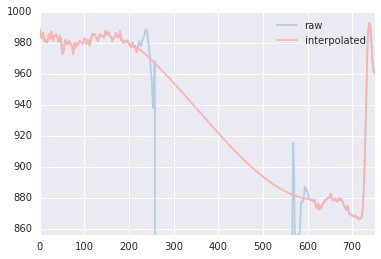

In [5]:
#check a trial with a blink in the 'middle' to verify script works
tmptrl = copy.deepcopy(edat[7][70])
plt.plot(tmptrl['x'], color = '#b3cde3', label = 'raw')
myfunctions.interpolateBlinks(tmptrl)
plt.plot(tmptrl['x'], color = '#fbb4ae', label = 'interpolated')
plt.legend()
plt.rcParams['figure.figsize'] = (7,7)
plt.xlim([0,750])
plt.ylim([1000-ppd*2,1000])

(700, 1000.0)

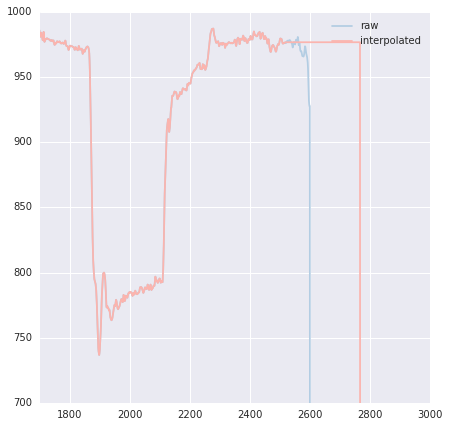

In [6]:
#check a trial with a single blink at the end
temp = copy.deepcopy(edat[7][85])
plt.figure()
plt.plot(edat[7][85]['x'], label = 'raw', color = '#b3cde3')
myfunctions.interpolateBlinks(temp)
plt.plot(temp['x'], label = 'interpolated', color = '#fbb4ae')
plt.legend()
plt.xlim([1700,None])
plt.ylim([700,None])

In [7]:
# go through every subject and trial to calculate saccadic response time for a given trial
# finds the first saccade of a trial after the target appears ('array' trigger)
# takes the time at which is starts, and subtracts the time at which the array appears, to calculate
# saccade response time
# saccades: start, end, duration, startx, starty, endx, endy

#edat = copy.deepcopy(edata)

for isub in range(len(edat)): #loop through participants
    sacctask = [x for x in range(len(edat[isub])) if edat[isub][x]['behaviour']['task'] == 2.0] # find trial indices of saccade task
    for i in sacctask: #loop saccade trials + find saccade response time (onset latency) of first saccade after target appears
        targettrig   = edat[isub][i]['triggers']['array'] #when the target appeared on screen
        fstime       = edat[isub][i]['trackertime'][0] #eyetracker start of trial
        if len(edat[isub][i]['events']['Esac']) > 0:
            trlsaccades  = np.array(edat[isub][i]['events']['Esac']) #extract saccades for trial
            trlsaccades  = trlsaccades[np.argsort(trlsaccades[:,0])] #sort saccades by start time
            inds         = np.squeeze(np.where(trlsaccades[:,0] >= targettrig[0])) # find saccades after probe
            if inds.size > 1:
                firstind = inds[0] #take first saccade after probe
                firstsaccade = trlsaccades[firstind]
                edat[isub][i]['behaviour']['fstime']       = fstime #add first sample time to behavioural data
                edat[isub][i]['behaviour']['firstsaccade'] = firstsaccade #add all saccade data
                edat[isub][i]['behaviour']['saccadetime']  = firstsaccade[0]-fstime - targettrig[1] #add just saccadic response time
            elif inds.size == 1: #only one saccade happened after the probe, so firstind = inds
                firstind = inds # firstind = 0, as only 1 saccade in trial
                firstsaccade = trlsaccades[firstind]
                edat[isub][i]['behaviour']['fstime']       = fstime
                edat[isub][i]['behaviour']['firstsaccade'] = firstsaccade
                edat[isub][i]['behaviour']['saccadetime']  = firstsaccade[0]-fstime - targettrig[1]
            elif inds.size == 0: #no saccades happened after the probe on this trial
                edat[isub][i]['behaviour']['fstime']       = fstime
                edat[isub][i]['behaviour']['firstsaccade'] = np.NaN
                edat[isub][i]['behaviour']['saccadetime']  = np.NaN
        elif len(edat[isub][i]['events']['Esac']) == 0: #no saccades happened on this trial
            edat[isub][i]['behaviour']['fstime']       = fstime
            edat[isub][i]['behaviour']['firstsaccade'] = np.NaN
            edat[isub][i]['behaviour']['saccadetime']  = np.NaN

# interpolate blinks in the gaze (x/y) data

# NB: this doesn't work on subject 4, where the data was collected at 250 Hz.
# need to find an acceptable way of removing blinks with the lower temporal resolution, as it cant be done effectively with the interpolateBlinks function, as it has inaccuracies in identification of blink end!

for isub in range(len(edat)):
    if sublist[isub] != 4:
        for trl in range(len(edat[isub])):
            myfunctions.interpolateBlinks(edat[isub][trl])
            
print 'done!'

done!


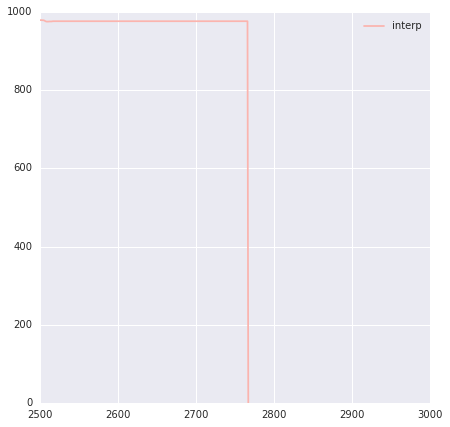

In [8]:
#check interpolation working on trial with two blinks at the end of the trial!
#temp = copy.deepcopy(edat[3][568])
#plt.rcParams['figure.figsize'] = (10,10)
#plt.plot(temp['x'], label = 'raw', color = '#b3cde3')
#myfunctions.interpolateBlinks(temp)
plt.plot(temp['x'], label = 'interp', color = '#fbb4ae')
plt.xlim([2500, None])
plt.legend()

In [9]:
# now all first saccades (after array) have been calculated, mark all trials where onset latency is less than 50ms as 'unusable'
# i.e. data[subject][trial]['behaviour']['sacc_allowed] = 0 for trials where the onset was too quick, 1 for trials where it was ok

for isub in range(len(edat)):
    if sublist[isub] != 4: #rm subject 4 cos 250Hz sample rate and haven't fixed yet
        sacctask = [x for x in range(len(edat[isub])) if edat[isub][x]['behaviour']['task']==2.0]
        for sactrl in sacctask:
            fsamp       = edat[isub][sactrl]['behaviour']['fstime']
            arrtime     = edat[isub][sactrl]['triggers']['array'][1]
            saccadetime = edat[isub][sactrl]['behaviour']['saccadetime']
            fsactime = edat[isub][sactrl]['behaviour']['firstsaccade']
            if type(fsactime)==float: #when there was no saccade after the target array appeared, fsactime is empty (but of 'float' type). use this fact to check if there was a saccade to use
                continue
            elif len(fsactime)>0: # just a sanity, check that fsactime has something in it, should have 7 things in it because it's a saccade
                if saccadetime <50:
                    edat[isub][sactrl]['behaviour']['sacc_allowed'] = 0
                elif saccadetime > 50:
                    edat[isub][sactrl]['behaviour']['sacc_allowed'] = 1

# check if ppt gazed beyond 2 degrees from fixation during cue-target interval. set value for trial rejection
# if unstable fixation set ['CT_stable'] -> 0
# If stable fixation, set ['CT_stable'] -> 1

# can then modify cell below to also verify that ['CT_stable'] is true, if not then don't include the trial in the analysis (should clean trials in line with nick's analysis plan)
ppd = 72 #72 pixels per degree of visual angle
fixpos = (960,540)
for isub in range(len(edat)):
    if sublist[isub] != 4: #rm subject 4 cos 250Hz sample rate and haven't fixed yet
        for trl in range(len(edat[isub])):
            epoch = [edat[isub][trl]['triggers']['cue'][1],edat[isub][trl]['triggers']['array'][1]]
            x = edat[isub][trl]['x'][epoch[0]:epoch[1]+1]; y = edat[isub][trl]['y'][epoch[0]:epoch[1]+1]
            if np.any(np.abs(myfunctions.Eucdist(fixpos[0], fixpos[1], x, y)) >= 2*ppd):
                edat[isub][trl]['behaviour']['CT_stable'] = 0
            else:
                edat[isub][trl]['behaviour']['CT_stable'] = 1

In [10]:
#check how many, per person, are going to be removed due to CT_stable
throwouts = []
saccthrows = []
for isub in range(len(edat)):
    if sublist[isub] != 4:
        throws   = [trl for trl in range(len(edat[isub])) if edat[isub][trl]['behaviour']['task']==2.0 and edat[isub][trl]['behaviour']['CT_stable'] == 0]
        sacc_all = [trl for trl in range(len(edat[isub])) if edat[isub][trl]['behaviour']['task']==2.0 and edat[isub][trl]['behaviour']['sacc_allowed'] == 0]
        thrw = len(throws)
        saccs = len(sacc_all)
        throwouts.append(thrw)
        saccthrows.append(saccs)

In [12]:
print throwouts
print saccthrows
for i in range(len(edat)):
    if sublist[i] != 4:
        print i, edat[i][0]['behaviour']['subject']
#2 degrees from fixation

[27, 281, 512, 621, 26, 35, 65]
[94, 28, 45, 48, 10, 3, 76]
0 1.0
1 2.0
3 5.0
4 6.0
5 7.0
6 8.0
7 9.0


False


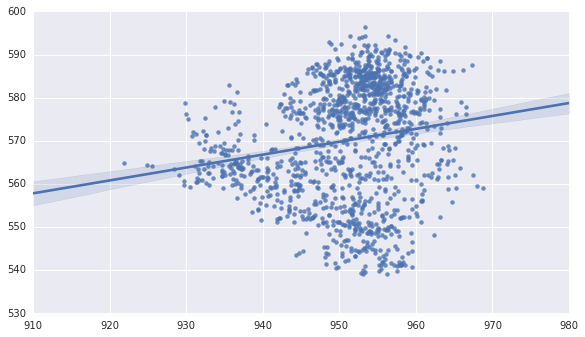

In [43]:
#import copy
temp = copy.deepcopy(edat[0]) # take subject 1 to work from. 1920 trials
#sacctask = [x for x in range(len(temp)) if temp[x]['behaviour']['task']==2.0] #0-10 are saccade trials lmao
trial = 59
epoch = [temp[trial]['triggers']['cue'][1], temp[trial]['triggers']['array'][1]]
x = temp[trial]['x'][epoch[0]:epoch[1]+1]; y = temp[trial]['y'][epoch[0]:epoch[1]+1]
print np.any(np.abs(np.subtract(x, 960)) >= ppd*2)
plt.rcParams['figure.figsize'] = (1.92*5,1.08*5) #set to similar aspect ratio as the screen the task was presented on!
sns.regplot(x,y) #scatter plot with line of best fit (i.e. trajectory of saccade)


In [47]:
edat[0][120]['behaviour']

{'CT_stable': 1,
 'corr': 1.0,
 'cuecol': 1.0,
 'cueloc': 3.0,
 'delay': 1.3394784167937601,
 'resp': 1.0,
 'sacc_allowed': 0,
 'session': nan,
 'subject': 1.0,
 'targloc': 3.0,
 'targlocpix': array([795, 939]),
 'targtilt': 1.0,
 'task': 1.0,
 'time': 0.57062813892662201,
 'validity': 1.0}

-5.28136082494 0.00114635449453 
average reaction time validty effect: -0.123347629318


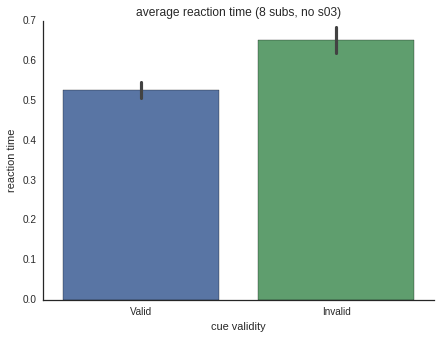

In [59]:
# just quickly try and get distributions of RT for the attention task -- only for correct trials
medvalRT = []
medinvRT = []

validRT = []; invalidRT = []

for isub in range(len(edat)):
    attval = [x for x in range(len(edat[isub])) if edat[isub][x]['behaviour']['task']==1.0 and edat[isub][x]['behaviour']['validity']==1.0 and edat[isub][x]['behaviour']['corr']==1.0]
    attinv = [x for x in range(len(edat[isub])) if edat[isub][x]['behaviour']['task']==1.0 and edat[isub][x]['behaviour']['validity']==0.0 and edat[isub][x]['behaviour']['corr']==1.0]
    valtrls = []; invtrls = []
    for i in attval:
        valtrls.append(edat[isub][i]['behaviour']['time'])
    for i in attinv:
        invtrls.append(edat[isub][i]['behaviour']['time'])
    medvalRT.append(np.nanmedian(valtrls)); validRT.append([valtrls])
    medinvRT.append(np.nanmedian(invtrls)); invalidRT.append([invtrls])
    
validRT = np.squeeze(np.array(validRT)); invalidRT = np.squeeze(np.array(invalidRT))
id = sublist
medvaltimedf = pd.DataFrame(medvalRT); medvaltimedf['subid'] = id; medvaltimedf['Validity'] = 'Valid'
medinvtimedf = pd.DataFrame(medinvRT); medinvtimedf['subid'] = id; medinvtimedf['Validity'] = 'Invalid'
medvaltimedf.columns = ['RT', 'id', 'Validity']
medinvtimedf.columns = ['RT', 'id', 'Validity']
plotRT    = pd.concat([medvaltimedf, medinvtimedf]) #meanvaltime and meaninvtime still contain data

plt.rcParams['figure.figsize']=(7,5)



statplot = sns.barplot(x = plotRT.Validity, y = plotRT.RT, ci = 68)
statplot.set_title('average reaction time (8 subs, no s03)')
statplot.set_xlabel('cue validity')
statplot.set_ylabel('reaction time')
sns.despine()
plt.savefig('./figures/barplot_medianRT_8subs.png')


test = stats.ttest_rel(medvalRT, medinvRT)
print test.statistic, test.pvalue, '\n', 'average reaction time validty effect: %s' %np.mean(np.subtract(medvalRT,medinvRT))

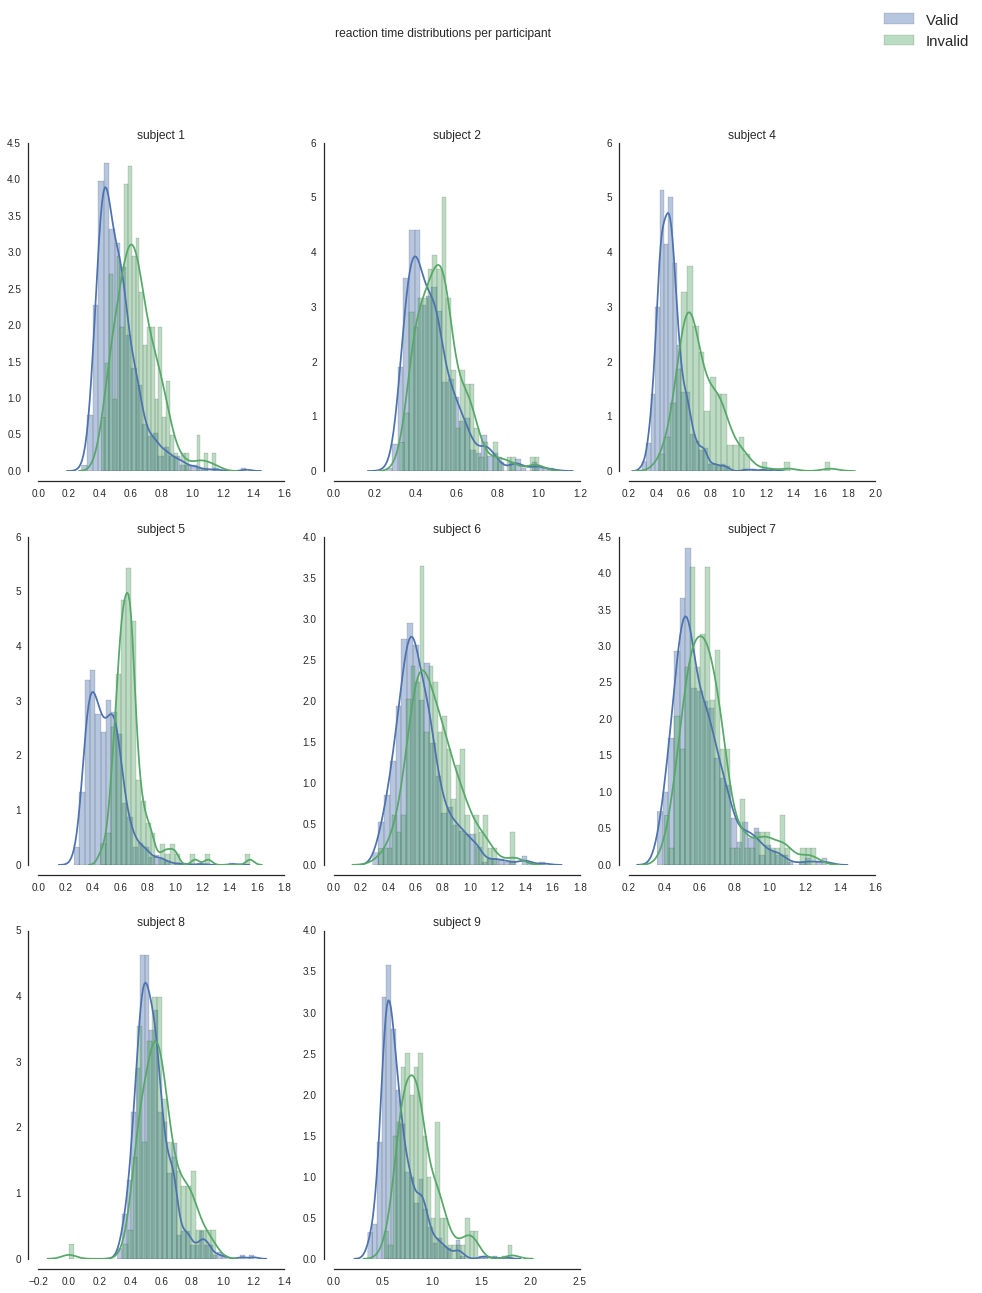

In [58]:
# plot figure showing individual subject reaction time distributions, by validity

subs = [0,1,2,3,4,5,6,7]
plt.rcParams['figure.figsize']=(15,20) # 3:2 ratio needed cos 3 columns 2 rows
subject_histplots = plt.figure()
subject_histplots.suptitle('reaction time distributions per participant')
sns.set(style = 'white')
for i in subs:
#    if sublist[i] == 4:
#        ax1 = subject_histplots.add_subplot(3,3,i+1, title = 'subject %s'%(sublist[i]))
#        sns.distplot(np.divide(valids[i],4),   bins = 30, ax = ax1, label = 'Valid')
#        sns.distplot(np.divide(invalids[i],4), bins = 30, ax = ax1, label = 'Invalid') # yellow histogram for invalids
#    else:
    ax1 = subject_histplots.add_subplot(3,3,i+1, title = 'subject %s'%(sublist[i]))
    sns.distplot(validRT[i],  bins = 30, ax = ax1, label = 'Valid')
    sns.distplot(invalidRT[i],bins = 30, ax = ax1, label = 'Invalid') # yellow histogram for invalids
sns.despine(offset = 10, trim = True) # removes the right and top axes from plot

handles, labels = ax1.get_legend_handles_labels()
subject_histplots.legend(handles, labels, prop = {'size':15})

subject_histplots.savefig('./figures/8subs_RTdistribution_ByValidity.pdf')

4.69526879091 0.00222077245418 
average accuracy validty effect: 9.73307291667


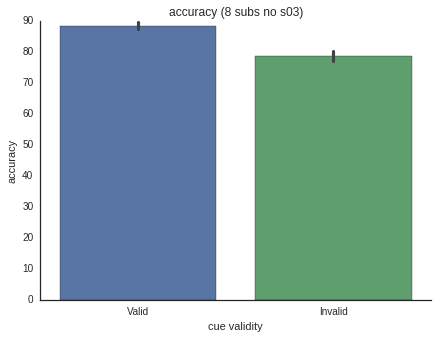

In [94]:
# quickly look at attention task RT accuracy
corrs = []; incorrs = []
accval= []; accinv = []
for isub in range(len(edat)):
    attval = [x for x in range(len(edat[isub])) if edat[isub][x]['behaviour']['task']==1.0 and edat[isub][x]['behaviour']['validity']==1.0]
    attinv = [x for x in range(len(edat[isub])) if edat[isub][x]['behaviour']['task']==1.0 and edat[isub][x]['behaviour']['validity']==0.0]
    correctval = []; incorrectval = []
    correctinv = []; incorrectinv = []
    for i in attval:
        if edat[isub][i]['behaviour']['corr']==1.0 :
            correctval.append(i)
        elif edat[isub][i]['behaviour']['corr']==0.0:
            incorrectval.append(i)
    for i in attinv:
        if edat[isub][i]['behaviour']['corr']==1.0 :
            correctinv.append(i)
        elif edat[isub][i]['behaviour']['corr']==0.0:
            incorrectinv.append(i)
    accval.append(float(len(correctval))/len(attval)*100.0)
    accinv.append(float(len(correctinv))/len(attinv)*100.0)

accval = np.squeeze(np.array(accval)); accinv = np.squeeze(np.array(accinv))
id = sublist
accvaldf = pd.DataFrame(accval); accvaldf['subid'] = id; accvaldf['Validity'] = 'Valid'
accinvdf = pd.DataFrame(accinv); accinvdf['subid'] = id; accinvdf['Validity'] = 'Invalid'
accvaldf.columns = ['accuracy', 'id', 'Validity']
accinvdf.columns = ['accuracy', 'id', 'Validity']
plotacc = pd.concat([accvaldf, accinvdf])

plt.rcParams['figure.figsize'] = (7,5)

statplot = sns.barplot(x=plotacc.Validity, y = plotacc.accuracy, ci = 68)
statplot.set_title('accuracy (8 subs no s03)')
statplot.set_xlabel('cue validity')
statplot.set_ylabel('accuracy')
sns.despine()
plt.savefig('./figures/barplot_meanAccuracy_8subs.png')

test = stats.ttest_rel(accval, accinv)
print test.statistic, test.pvalue, '\n', 'average accuracy validty effect: %s' %np.mean(np.subtract(accval,accinv))

In [89]:
valids   = np.squeeze(np.array(valids))
invalids = np.squeeze(np.array(invalids))
id = sublist
medianvaltimedf = pd.DataFrame(medianvaltime); medianvaltimedf['subid'] = id; medianvaltimedf['Validity'] = 'Valid'
medianinvtimedf = pd.DataFrame(medianinvtime); medianinvtimedf['subid'] = id; medianinvtimedf['Validity'] = 'Invalid'
medianvaltimedf.columns = ['ST', 'id', 'Validity']
medianinvtimedf.columns = ['ST', 'id', 'Validity']
plotting    = pd.concat([medianvaltimedf, medianinvtimedf]) #meanvaltime and meaninvtime still contain data

# # # # # # # stats on saccade onset latency # # # # # # #
plt.rcParams['figure.figsize']=(7,5)

statplot = sns.barplot(x = plotting.Validity, y = plotting.ST, ci = 68)
statplot.set_title('average saccade onset latency (8 subs, no s03)')
statplot.set_xlabel('cue validity')
statplot.set_ylabel('saccade time')
sns.despine()
plt.savefig('./figures/barplot_medianSaccadetime_9subs.png')


test = stats.ttest_rel(medianvaltime, medianinvtime)
print test.statistic, test.pvalue, '\n', 'average saccade time validty effect: %s' %np.mean(np.subtract(medianvaltime,medianinvtime))

[89.97395833333334, 88.15104166666666, 94.921875, 92.1875, 83.46354166666666, 88.15104166666666, 84.765625, 85.9375]
[85.41666666666666, 86.97916666666666, 79.6875, 73.95833333333334, 77.60416666666666, 80.20833333333334, 73.95833333333334, 71.875]


In [ ]:
# this will need modifying slightly when the cell above is tweaked to allow for better/different selection of trials for analysis
# e.g. sacval = [x for x in range(len(edat[isub])) if ..... and edat[isub][x]['behaviour']['CT_stable'] == 1] #only choose trials where fixation was maintained during the cue-target interval

medianvaltime = []
medianinvtime = []
valids      = []; invalids = []
for isub in range(len(edat)):
    if sublist[isub] == 4: # subject 4, sample rate was 250hz so saccade onset is out by a factor of 4 (vs. 1000hz sample rate)
        sacval = [x for x in range(len(edat[isub])) if edat[isub][x]['behaviour']['task']==2.0 and edat[isub][x]['behaviour']['validity']==1.0 and edat[isub][x]['behaviour']['sacc_allowed']==1]
        sacinv = [x for x in range(len(edat[isub])) if edat[isub][x]['behaviour']['task']==2.0 and edat[isub][x]['behaviour']['validity']==0.0 and edat[isub][x]['behaviour']['sacc_allowed']==1]
        valtrls = []; invtrls = []
        for i in sacval:
            valtrls.append(edat[isub][i]['behaviour']['saccadetime']/4)
        for i in sacinv:
            invtrls.append(edat[isub][i]['behaviour']['saccadetime']/4)
        valtrials = []; invtrials = []
        valtrlz = [x for x in range(len(valtrls)) if np.isnan(valtrls[x])==False]
        invtrlz = [y for y in range(len(invtrls)) if np.isnan(invtrls[y])==False]
        for i in valtrlz:
            valtrials.append(valtrls[i])
        for i in invtrlz:
            invtrials.append(invtrls[i])
        medianvaltime.append(np.median(valtrials)); valids.append([valtrials])
        medianinvtime.append(np.median(invtrials)); invalids.append([invtrials])
    elif sublist[isub] != 4:
        sacval = [x for x in range(len(edat[isub])) if edat[isub][x]['behaviour']['task']==2.0 and edat[isub][x]['behaviour']['validity']==1.0 and edat[isub][x]['behaviour']['sacc_allowed']==1]
        sacinv = [x for x in range(len(edat[isub])) if edat[isub][x]['behaviour']['task']==2.0 and edat[isub][x]['behaviour']['validity']==0.0 and edat[isub][x]['behaviour']['sacc_allowed']==1]
        valtrls = []; invtrls = []
        for i in sacval:
            valtrls.append(edat[isub][i]['behaviour']['saccadetime'])
        for i in sacinv:
            invtrls.append(edat[isub][i]['behaviour']['saccadetime'])
        valtrials = []; invtrials = []
        valtrlz = [x for x in range(len(valtrls)) if np.isnan(valtrls[x])==False]
        invtrlz = [y for y in range(len(invtrls)) if np.isnan(invtrls[y])==False]
        for i in valtrlz:
            valtrials.append(valtrls[i])
        for i in invtrlz:
            invtrials.append(invtrls[i])
        medianvaltime.append(np.median(valtrials)); valids.append([valtrials])
        medianinvtime.append(np.median(invtrials)); invalids.append([invtrials])

valids   = np.squeeze(np.array(valids))
invalids = np.squeeze(np.array(invalids))
id = sublist
medianvaltimedf = pd.DataFrame(medianvaltime); medianvaltimedf['subid'] = id; medianvaltimedf['Validity'] = 'Valid'
medianinvtimedf = pd.DataFrame(medianinvtime); medianinvtimedf['subid'] = id; medianinvtimedf['Validity'] = 'Invalid'
medianvaltimedf.columns = ['ST', 'id', 'Validity']
medianinvtimedf.columns = ['ST', 'id', 'Validity']
plotting    = pd.concat([medianvaltimedf, medianinvtimedf]) #meanvaltime and meaninvtime still contain data

# # # # # # # stats on saccade onset latency # # # # # # #
plt.rcParams['figure.figsize']=(7,5)

statplot = sns.barplot(x = plotting.Validity, y = plotting.ST, ci = 68)
statplot.set_title('average saccade onset latency (8 subs, no s03)')
statplot.set_xlabel('cue validity')
statplot.set_ylabel('saccade time')
sns.despine()
plt.savefig('./figures/barplot_medianSaccadetime_9subs.png')


test = stats.ttest_rel(medianvaltime, medianinvtime)
print test.statistic, test.pvalue, '\n', 'average saccade time validty effect: %s' %np.mean(np.subtract(medianvaltime,medianinvtime))

In [ ]:
# plot figure showing individual subjects saccade latencies by validity

subs = [0,1,2,3,4,5,6,7]
plt.rcParams['figure.figsize']=(15,20) # 3:2 ratio needed cos 3 columns 2 rows
subject_histplots = plt.figure()
subject_histplots.suptitle('saccade time distributions per participant')
sns.set(style = 'white')
for i in subs:
#    if sublist[i] == 4:
#        ax1 = subject_histplots.add_subplot(3,3,i+1, title = 'subject %s'%(sublist[i]))
#        sns.distplot(np.divide(valids[i],4),   bins = 30, ax = ax1, label = 'Valid')
#        sns.distplot(np.divide(invalids[i],4), bins = 30, ax = ax1, label = 'Invalid') # yellow histogram for invalids
#    else:
    ax1 = subject_histplots.add_subplot(3,3,i+1, title = 'subject %s'%(sublist[i]))
    sns.distplot(valids[i],  bins = 30, ax = ax1, label = 'Valid')
    sns.distplot(invalids[i],bins = 30, ax = ax1, label = 'Invalid') # yellow histogram for invalids
sns.despine(offset = 10, trim = True) # removes the right and top axes from plot

handles, labels = ax1.get_legend_handles_labels()
subject_histplots.legend(handles, labels, prop = {'size':15})

subject_histplots.savefig('./figures/9subs_st_distributions_validity.pdf')

In [ ]:
# plot valid and invalid trials for each subject, on separate plots

plt.rcParams['figure.figsize']=(8,5)
validplot = plt.figure()
for i in range(len(valids)):
    sns.distplot(valids[i], bins = 30)
validplot.suptitle('valid trial saccade times for all participants')
sns.despine()
invalidplot = plt.figure()
for i in range(len(invalids)):
    sns.distplot(invalids[i], bins = 30)
invalidplot.suptitle('invalid trial saccade times for all participants')
sns.despine()

In [ ]:
# accuracy analysis
# 
# 1 - if euclidian distance of saccade destination from target location beyond threshold value, mark as incorrect (need binary for the DDM modelling)

# 2 - euclidian distance of saccade destination from target location, no judgement on correctness. continuous variable for non-binary analysis

# 3 - circular angle between saccade destination and target location (and also from cued location on invalid trials)
#     can then do circular stats on this and look at biasing effects on invalid trials
 
 

In [ ]:
#get precision of a saccade (euclidian distance of saccade end point from a coordinate (of centre of target))
#check if within certain error range (100 pix appropriate?)

#these target locations aren't right, waiting on nick for them
#need to correct coordinates to transform from eyetracker space to normal cartesian space

#EP locations
eptarglocations = np.array([[288,119], # cueloc = 1
                           [119, 288], # cueloc = 2
                           [-119, 288],# cueloc = 3
                           [-288, 119],# cueloc = 4
                           [-288,-119],# cueloc = 5
                           [-119,-288],# cueloc = 6
                           [119,-288], # cueloc = 7
                           [288,-119]] # cueloc = 8
                           )

#ohba locations
obtarglocations = np.array([[399,165],  # cueloc = 1
                           [165, 399], # cueloc = 2
                           [-165, 399],# cueloc = 3
                           [-399, 165],# cueloc = 4
                           [-399,-165],# cueloc = 5
                           [-165,-399],# cueloc = 6
                           [165,-399], # cueloc = 7
                           [399,-165]] # cueloc = 8
                           )
eptarglocations[:,0] = eptarglocations[:,0]+(resxy[0]/2) # correct x from tracker coords to normal coords
eptarglocations[:,1] = eptarglocations[:,1]+(resxy[1]/2) # correct y from tracker coords to normal coords

obtarglocations[:,0] = obtarglocations[:,0]+(resxy[0]/2) # correct x from tracker coords to normal coords
obtarglocations[:,1] = obtarglocations[:,1]+(resxy[1]/2) # correct y from tracker coords to normal coords


#temp = edat[1] #read in subject 5, 1khz sample rate eyetracking
#saccvals = [x for x in range(len(temp)) if temp[x]['behaviour']['task']==2.0 and temp[x]['behaviour']['validity']==1.0]
#loc1 = [y for y in saccvals if temp[y]['behaviour']['cueloc'] == 1.0]
#print loc1, '\n'

#print targlocations[0], '\n'
#print temp[0]['behaviour']['firstsaccade'], '\n'
#print temp[0]['events']['Efix']
